## eye detection

In [2]:
from glob import glob
image_data = glob('./Gaze360/*.jpg')
print(len(image_data))

1346


In [84]:
import mediapipe as mp
import cv2
import numpy as np
from tqdm import tqdm

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

cap = cv2.VideoCapture(0)

def get_eye_region(landmarks, indexes, image):
    # 랜드마크 좌표를 사용하여 눈 영역 추출
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * image.shape[1])
        y = int(landmarks[idx].y * image.shape[0])
        points.append([x, y])
    return np.array(points, dtype=np.int32)

def get_iris_center(landmarks, iris_indexes, image):
    # 홍채 중심 좌표 계산
    iris_points = np.array([[landmarks[idx].x * image.shape[1], landmarks[idx].y * image.shape[0]] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    val_iris_center = np.mean(iris_points, axis=0)
    return iris_center, val_iris_center

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

def evaludate_mediapipe(image_paths, image_labels):
    
    eye_result = []
    eye_direction_list = []
    for i, img_path in tqdm(enumerate(image_paths)):
        
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        result = face_mesh.process(image_rgb)
        
        if not result.multi_face_landmarks:
            # print(f'No pose detected in {img_path, i}')
            eye_result.append([])
            eye_direction_list.append([])
            continue

        for face_landmark in result.multi_face_landmarks:
            
            # 왼쪽 눈과 오른쪽 눈 영역 추출 (크기 비율 적용)
            left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, image)
            right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, image)

            # 눈 영역에 다각형 그리기
            # cv2.polylines(image, [left_eye], isClosed=True, color=(0, 255, 0), thickness=1)
            # cv2.polylines(image, [right_eye], isClosed=True, color=(0, 255, 0), thickness=1)

            # 왼쪽 및 오른쪽 홍채 중심 추출
            left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, image)
            right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, image)
            # left_iris_list.append(val_left_iris_center)
            # right_iris_list.append(val_right_iris_center)
            # left_uclid_distance.append(np.linalg.norm(left_eye - val_left_iris_center))
            # right_uclid_distance.append(np.linalg.norm(right_eye - val_right_iris_center))
            # 홍채 중심에 원 그리기
            # cv2.circle(image, tuple(left_iris_center), 3, (255, 0, 0), -1)
            # cv2.circle(image, tuple(right_iris_center), 3, (255, 0, 0), -1)
            
            # 왼쪽 눈동자 중심 계산
            left_eye_center = np.mean(left_eye, axis=0)
            right_eye_center = np.mean(right_eye, axis=0)
            
            eye_result.append([left_eye, left_eye_center, left_iris_center, right_eye, right_eye_center, right_iris_center])
            
            left_eye_direction = ''
            right_eye_direction = ''

            if  abs(left_eye_center[0] - val_left_iris_center[0]) <= 1 and abs(left_eye_center[1] - val_left_iris_center[1]) <= 1:
                left_eye_direction = 'center'
            elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 1 and  left_eye_center[1] - val_left_iris_center[1] > 1:
                left_eye_direction = 'top'
            elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 1 and  left_eye_center[1] - val_left_iris_center[1] < 1:
                left_eye_direction = 'bottom'
            elif left_eye_center[0] - val_left_iris_center[0] > 1:
                left_eye_direction = 'left'
            elif left_eye_center[0] - val_left_iris_center[0] < -1:
                left_eye_direction = 'right'

            if  abs(right_eye_center[0] - val_right_iris_center[0]) <= 1 and abs(right_eye_center[1] - val_right_iris_center[1]) <= 1:
                right_eye_direction = 'center'
            elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 1 and right_eye_center[1] - val_right_iris_center[1] > 1:
                right_eye_direction = 'top'
            elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 1 and right_eye_center[1] - val_right_iris_center[1] < 1:
                right_eye_direction = 'bottom'
            elif right_eye_center[0] - val_right_iris_center[0] > 1:
                right_eye_direction = 'left'
            elif right_eye_center[0] - val_right_iris_center[0] < -1:
                right_eye_direction = 'right'
            
            eye_direction_list.append([left_eye_direction, right_eye_direction])
    
    return eye_result, eye_direction_list

[ WARN:0@1533.287] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1533.287] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
I0000 00:00:1729162673.992601   99834 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1729162674.013000  120540 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: D3D12 (Intel(R) UHD Graphics)


In [85]:
eye_result, eye_direction_list = evaludate_mediapipe(image_data, image_labels=[])

1346it [00:08, 158.47it/s]


In [86]:
print(len(eye_result))
print(len(eye_direction_list))

1346
1346


In [87]:
# print(eye_result[0])

In [88]:
import matplotlib.pyplot as plt

def visualize_img(image_path, eye_result):
    # print(eye_result[2][0], eye_result[2][1])
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    plt.scatter(eye_result[1][0], eye_result[1][1], color='blue', label='Predicted', s=10)
    plt.scatter(eye_result[2][0], eye_result[2][1], color='red', label='Predicted', s=10)
    plt.scatter(eye_result[4][0], eye_result[4][1], color='blue', label='Predicted', s=10)
    plt.scatter(eye_result[5][0], eye_result[5][1], color='red', label='Predicted', s=10)

    # plt.legend('eye_center', 'iris_center')

    plt.show()

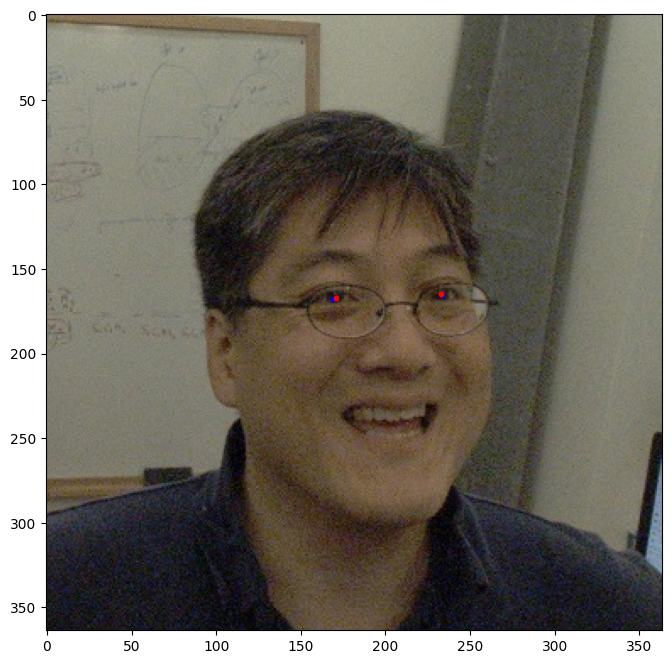

['right', 'center']


In [95]:
visualize_img(image_data[58], eye_result[58])
print(eye_direction_list[58])